In [2]:
import os
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

%matplotlib inline

In [28]:
# read gathered statistics data

output_paths = [
    # 'evosuite.csv',
    # '~/evosuite-stat.csv',
    # '~/evokex-16-15.csv', 
    # "~/evokex-32-5.csv",
    # "~/evokex-32-15.csv", 
    # "~/evokex-16-15-u.csv",
    # "~/evokex-32-5-u.csv",
    # "~/evokex-32-5-g-1.csv",
    # "~/evokex-32-5-g-2.csv",
    # "~/evokex-32-5-g-3.csv",
    # "~/evokex-32-5-g-4.csv",
    # "~/evokex-32-5-g-5.csv",
    # "~/evokex-32-5-g-6.csv",
    # "~/evokex-32-5-l-1.csv",
    # "~/evokex-32-5-l-2.csv",
    # "~/evokex-32-5-l-3.csv",
    # "~/evokex-32-5-l-4.csv",

    # "~/evosuite-gu.csv",
    "~/evosuite-stat-gu.csv",
    # "~/evokex-32-5-gu.csv",
    # "~/evokex-32-5-l-1-gu.csv",
    # "~/evokex-32-5-l-4-gu.csv",
    "~/evokex-32-5-h-1-gu.csv",
    "~/evokex-32-5-h-2-gu.csv",
]
raw_data: pd.DataFrame = None
for output_path in output_paths:
    tmp = pd.read_csv(output_path)
    if "stat" in output_path:
        tmp['tool'] = tmp['tool'].apply(lambda x: x + '-2')
    if raw_data is None:
        raw_data = tmp
    else:
        raw_data = pd.concat([raw_data, tmp])

In [29]:
raw_data['project'] = raw_data['benchmark'].apply(lambda x: x[:x.rindex('-')])

In [30]:
# some additional filters

# raw_data = raw_data[raw_data['timeout'] == 120]

In [31]:
len(raw_data)

450

In [32]:
# filter out "bad" benchmarks

tools = set(raw_data['tool'].unique())
timeouts = set(raw_data['timeout'].unique())

grouped = raw_data.groupby('benchmark')
mask = grouped.apply(lambda x: len(x.drop_duplicates(subset=['tool', 'timeout'])) == len(tools) * len(timeouts))
raw_data = raw_data[raw_data['benchmark'].map(mask)]

len(raw_data)

450

In [19]:
print("Deleted benchmarks:")
for bench in mask.index:
    if not mask[bench]:
        print(bench)

In [20]:
data_indexed = raw_data.set_index(['tool', 'timeout', 'project'], drop=False).sort_index()

In [22]:
# calculate weighted statistics

def get_weighted_stats(x, w=None, mn=None, mx=None, **kwargs):
    stats = DescrStatsW(x, w, ddof=1)

    q1, q2, q3 = stats.quantile([0.25, 0.5, 0.75], return_pandas=False)
    iqr = q3 - q1

    whishi = q3 + 1.5 * iqr
    if mx is not None:
        whishi = min(mx, whishi)

    whislo = q1 - 1.5 * iqr
    if mn is not None:
        whislo = max(mn, whislo)

    fliers = x.loc[(x > whishi) | (x < whislo)]

    return {
        'mean': stats.mean,
        'q1': q1,
        'med': q2,
        'q3': q3,
        'iqr': iqr,
        'whishi': whishi,
        'whislo': whislo,
        'fliers': list(fliers),
        'std': stats.std,
        **kwargs
    }


In [23]:
tools = list(data_indexed.index.unique(0))
timeouts = list(data_indexed.index.unique(1))
projects = list(data_indexed.index.unique(2))

In [24]:
# constructing the most interesting statistics

def full_stats_dict():
    return {
        'default': None,
        'weighted': None,
        '1 / weighted': None,
    }


def compute_stats_by(df: pd.DataFrame, name: str, mod: str, weighted: int) -> dict:
    label = f'{name}_{mod}'
    weights = None
    if weighted == 1:
        label += ' (w)'
        weights = df[f'{name}_total']
    elif weighted == 2:
        label += ' (1/w)'
        weights = 1. / (df[f'{name}_total'] + 1)
    return get_weighted_stats(
        df[f'{name}_{mod}_ratio'],
        weights,
        mn=0, mx=100,
        label=label
    )


def compute_stats(df: pd.DataFrame, weighted: int) -> dict:
    return {
        'lines_coverage': compute_stats_by(df, 'lines', 'coverage', weighted),
        'branches_coverage': compute_stats_by(df, 'branches', 'coverage', weighted),
        'instructions_coverage': compute_stats_by(df, 'instructions', 'coverage', weighted),
        'complexity_coverage': compute_stats_by(df, 'complexity', 'coverage', weighted),
    }


global_stats = defaultdict(
    lambda: defaultdict(
        lambda: {
            'projects': defaultdict(lambda: full_stats_dict()),
            **full_stats_dict()
        }
    )
)

for tool in tools:
    for timeout in timeouts:
        dt = data_indexed.loc[tool, timeout]
        stats = global_stats[tool][timeout]
        stats['default'] = compute_stats(dt, weighted=0)
        stats['weighted'] = compute_stats(dt, weighted=1)
        stats['1 / weighted'] = compute_stats(dt, weighted=2)

        stats = stats['projects']
        for project in projects:
            dt = data_indexed.loc[tool, timeout, project]
            p_stats = stats[project]
            p_stats['default'] = compute_stats(dt, weighted=0)
            p_stats['weighted'] = compute_stats(dt, weighted=1)
            p_stats['1 / weighted'] = compute_stats(dt, weighted=2)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/weightstats.

In [25]:
# group statistics by tool, timeout and project

table = pd.DataFrame(
    index=pd.MultiIndex.from_product([['ALL'] + projects, timeouts, tools], names=['project', 'timeout', 'tool']),
    columns=['lines', 'branches', 'instructions', 'complexity', 'lines (w)', 'branches (w)', 'instructions (w)', 'complexity (w)', 'lines (1/w)', 'branches (1/w)', 'instructions (1/w)', 'complexity (1/w)']
)

metric = 'mean'

def extract(x):
    return [x['lines_coverage'][metric], x['branches_coverage'][metric], x['instructions_coverage'][metric],
            x['complexity_coverage'][metric]]


for timeout in timeouts:
    for tool in tools:
        stats = global_stats[tool][timeout]
        item = [*extract(stats['default']), *extract(stats['weighted']), *extract(stats['1 / weighted'])]
        table.loc['ALL', timeout, tool] = item
        for project in projects:
            stats = global_stats[tool][timeout]['projects'][project]
            item = [*extract(stats['default']), *extract(stats['weighted']), *extract(stats['1 / weighted'])]
            table.loc[project, timeout, tool] = item

table[[col for col in table if col.startswith('lines')]]

lines  lines (w) lines (1/w)
project timeout tool                                             
ALL     120     evokex-16-15     60.418769  53.665019   67.356481
                evokex-16-15-u   56.137538   57.11247    58.73611
                evokex-32-15     60.648667  51.496716   67.741631
                evokex-32-5      62.405538  55.837221   66.003016
                evokex-32-5-g-1  57.460462  51.667707   63.664072
...                                    ...        ...         ...
SPOON   120     evokex-32-5-l-2  47.353778   37.62918   49.666162
                evokex-32-5-l-3       38.6  26.749166   44.665612
                evokex-32-5-l-4  36.910222  26.555799   39.818599
                evokex-32-5-u        49.71  34.643456   56.918415
                evosuite-stat-2  45.914444  37.768948   50.945707

[80 rows x 3 columns]

In [46]:
metrics = [
    'lines_coverage',
    'branches_coverage',
    'instructions_coverage',
    'complexity_coverage',
]

print('tools:', ', '.join(tools))
print('timeouts:', ', '.join([str(x) for x in timeouts]))
print('projects:', ', '.join(projects))
print('metrics:', ', '.join(metrics))

tools: evokex-32-5
timeouts: 30, 120
projects: BYTEBUDDY, ERRORPRONE, JAVAPOET
metrics: lines_coverage, branches_coverage, instructions_coverage, complexity_coverage


In [47]:
# stuff for boxplots

def get_cmap(n, name='brg'):
    return plt.colormaps.get_cmap(name).resampled(n)


def draw_boxplots(ax: plt.Axes, labels, mods, get_stats, width=0.07, gap=1):
    colors = get_cmap(len(mods))
    n = len(mods)
    pos_diff = np.linspace(-n + 1, n - 1, n) * (width / 2)
    x_tick_label = []
    x_tick_position = []

    for i, label in enumerate(labels):
        for j, mod in enumerate(mods):
            x_tick_label.append(label)
            x_tick_position.append(i * gap)
            p = i * gap + pos_diff[j]

            stats = get_stats(label, mod)
            bxp = ax.bxp([stats], widths=[width], patch_artist=True, positions=[p])
            for box in bxp["boxes"]:
                box.update(dict(
                    facecolor=colors(j),
                    zorder=.9,
                    edgecolor='gray',
                ))
            if i == 0:
                rect = plt.Rectangle((0, 0), 0, 0,
                                     linewidth=0,
                                     edgecolor='gray',
                                     facecolor=colors(j),
                                     label=mod)
                ax.add_patch(rect)

    plt.xticks(x_tick_position, x_tick_label)


In [49]:
def draw_per_project(metric, weighted, tool):
    fig, ax = plt.subplots(figsize=(9, 4))

    def get_stats(project, timeout):
        stats = global_stats[tool][timeout]['projects'][project]
        if weighted == 0:
            stats = stats['default']
        elif weighted == 1:
            stats = stats['weighted']
        else:
            stats = stats['1 / weighted']
        return stats[metric]

    draw_boxplots(ax, projects, timeouts, get_stats, 0.15)

    ax.legend(loc='upper left', title='timeouts (s)', bbox_to_anchor=(1, 1))
    title = f'{tool}: {metric}'
    if weighted == 1:
        title += ' (w)'
    elif weighted == 2:
        title += ' (1/w)'
    ax.set_title(title)


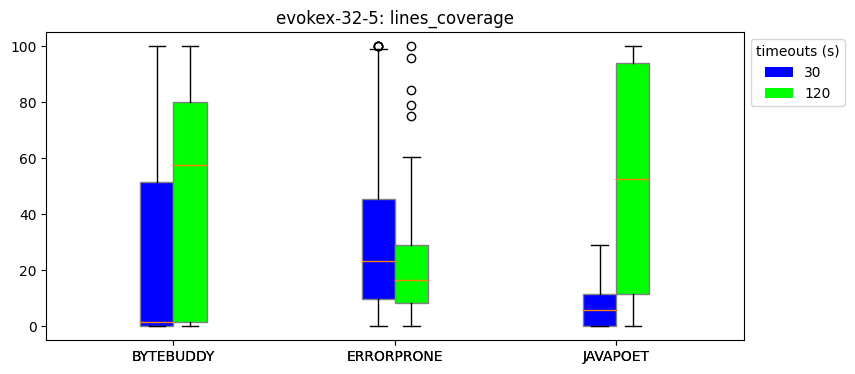

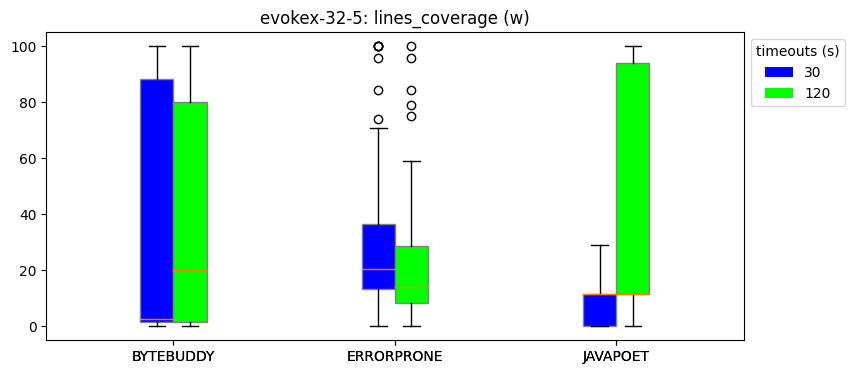

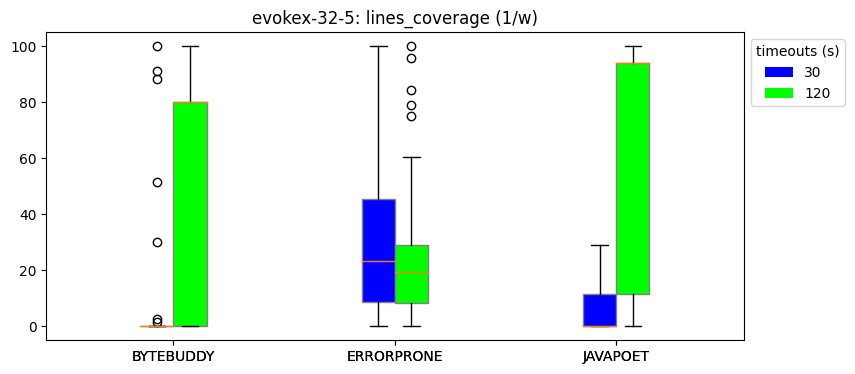

In [50]:
# draw boxplots for each tool

metric = 'lines_coverage'
for weighted in [0, 1, 2]:
    for tool in tools:
        draw_per_project(metric, weighted, tool)
plt.show()

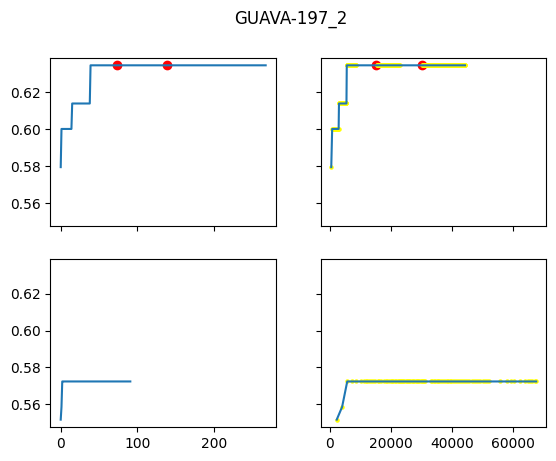

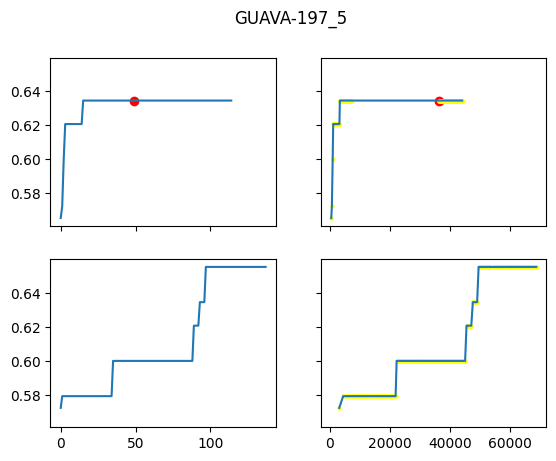

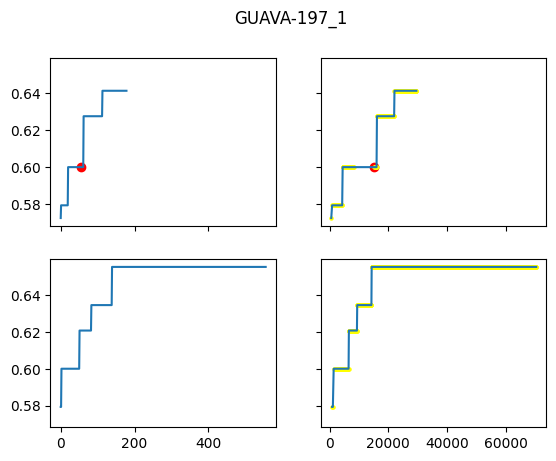

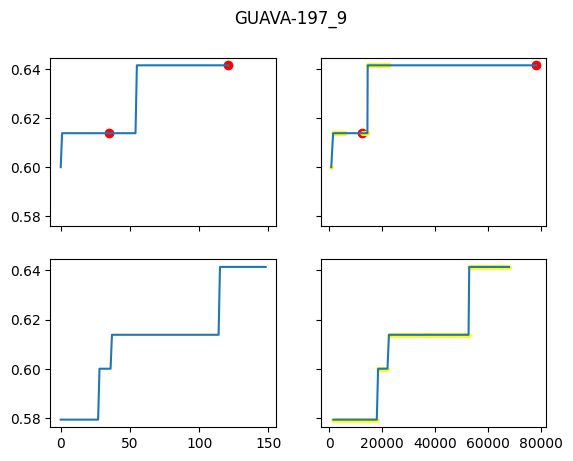

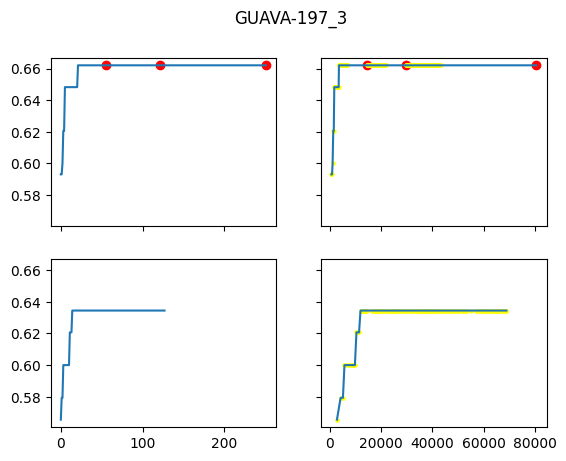

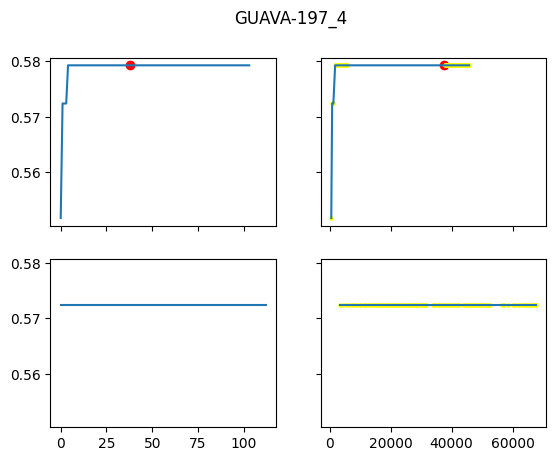

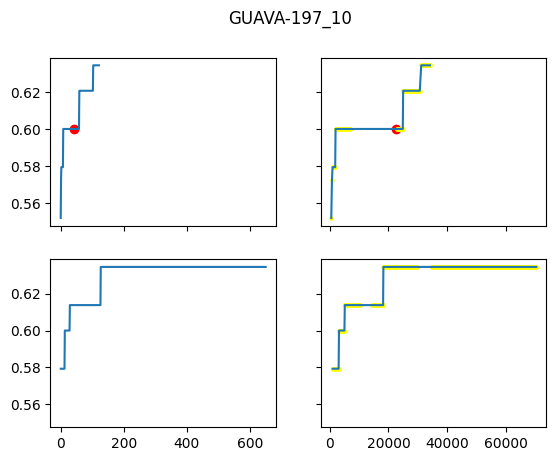

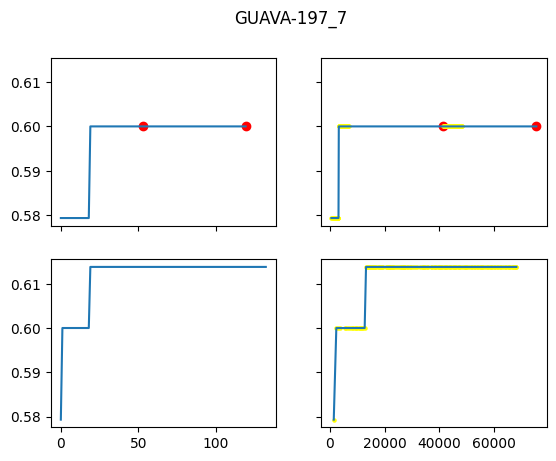

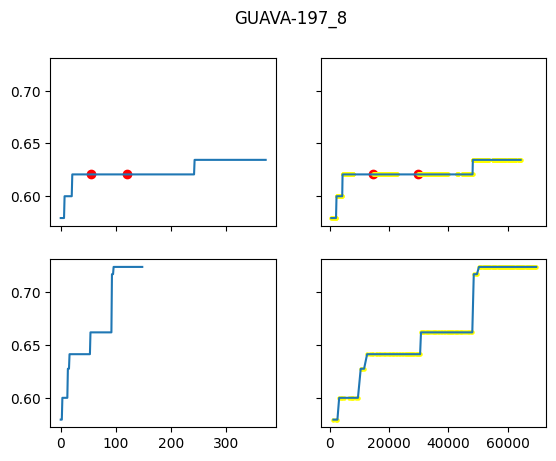

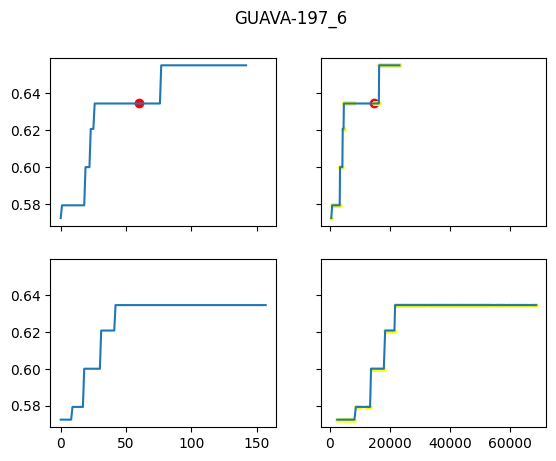

In [38]:
# draw plots for coverage saturation

page = 0
sz = 1000

i = 0

def fill_plots(ax, bx, folder, file):
    data = []
    times = []
    prev_is_target = False
    with open(os.path.join(folder, file)) as f:
        for line in f:
            result = re.search(r"^Coverage: (\d+)/(\d+)", line)
            if result is not None:
                a, b = result.groups()
                data.append(int(a) / int(b))
            else:
                result = re.search(r"^Targeted: (\w+)", line)
                if result is not None:
                    t = result.groups()[0]
                    if t == 'true':
                        prev_is_target = True
                        if data[-1] > data[-2]:
                            color = 'green'
                        else:
                            color = 'red'
                        ax.scatter(len(data)-1, data[-1], color=color, marker='o')
                else:
                    result = re.search(r"^Time: (\d+)", line)
                    if result is not None:
                        t = result.groups()[0]
                        times.append(int(t))
                        if prev_is_target:
                            bx.scatter(int(t), data[-1], color=color, marker='o')
                            prev_is_target = False
                        else:
                            bx.scatter(int(t), data[-1], color='yellow', marker='o', s=5)
    x = list(range(len(data)))
    ax.plot(x, data)
    bx.plot(times, data)

bench_name = sorted(raw_data['benchmark'].unique())[5]

for folder, _, files in os.walk('/home/rustamsadykov/stats/evokex-32-5-h-2-120'):
    name = os.path.basename(folder)
    if (not name.startswith(bench_name)
            # or not name.endswith("_1")
    ):
        continue
    if i >= (page + 1) * sz:
        break
    for file in files:
        if i < page * sz or i >= (page + 1) * sz:
            i += 1
            continue
        i += 1
        if file != 'work-stat.log':
            continue

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex='col', sharey=True)
        fig.suptitle(name)
        fill_plots(ax1, ax2, folder, file)
        fill_plots(ax3, ax4, folder.replace('evokex-32-5-h-2-120', 'evosuite-stat-120'), file)
plt.show()